# Fine-tuning RoBERTa using LoRA

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from lora_modules import LoRARobertaSdpaSelfAttention
from torch.nn.parameter import Parameter
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR, SequentialLR
from utils import get_loss_and_accuracy, SST2Dataset
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Let's create 2 identical instances of the RoBERTa-base model. We will keep one intact and modify the other with LoRA modules.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
torch.manual_seed(42)
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
torch.manual_seed(42)
model_original = RobertaForSequenceClassification.from_pretrained('roberta-base')

model.to(device)
model_original.to(device)

### Model architecture:

Before we start, let's take a look at the model architecture:

In [3]:
model_original

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Here is the data flow:

* Firstly, the input tokens are converted into embeddings by the `RobertaEmbeddings` layer. 

* The embeddings are then fed into the `RobertaEncoder`, which consists of 12 stacked `RobertaLayers`. Each layer has a **self-attention mechanism**, along with feed-forward network.

* The encoder outputs go through a few more linear layers - `RobertaIntermediate` and `RobertaOutput`. This is also the end of the pretrained model.

When we initiate the modal for binary sentiment classification, a `RobertaClassificationHead` is attached. Its weights are randomly initiated (not pre-trained), and we need to train them before running inferences.

The building block for all of the above modules are `nn.Linear` layers. 

For a linear layer with `in_features = 768` and `out_features = 768`, there will be a weight matrix `W` of shape `[768, 768]` and an optional `bias` of shape `[768]`. In a full fine-tuning, all of these parameters will be updated.

### What is LoRA?

The LoRA paper suggests that we actually do not need to retrain the whole `W` matrix. Particularly, for a matrix $W_0 \in \mathbb{R}^{d \times k}$, we represent the update with a low-rank decomposition:

$$
W_0 + \Delta W = W_0 + BA, \text{ where } B \in \mathbb{R}^{d \times r}, A \in \mathbb{R}^{r \times k}, \text{ and the rank } r \ll \min(d, k).
$$

We will only train $B$ and $A$ during fine-tuning, and keep the pre-trained weights untouched.

The original forward pass is $h = W_0 \mathbf{x}$. With LoRA fine-tuning, the forward pass will be:
$$
h = W_0 \mathbf{x} + \Delta W \mathbf{x} = W_0 \mathbf{x} + B A \mathbf{x}
$$

In our specfic case, the author chose the rank $\mathbf{r}$ to be 8. Therefore, $B$ and $A$ will have shape `[768, 8]` and `[8, 768]` respectively.

This method result in much less parameter to train:

* Original trainable parameters: $768 * 768 = 589,824$
* LoRA trainable parameters: $768 * 8 + 8 * 768 = 12,288$

### Where will LoRA be applied?

This will be applied on the **attention modules only**. Particularly, we only modify the `query` and the `value` layers of the attention modules, while keeping the other parts intact.

### Implementation details:

From the model architecture above, the attention module in RoBERTa-base is `RobertaSdpaSelfAttention`. This module has the following inheritance chain:

<div style="text-align: center;">
 <code>RobertaSdpaSelfAttention</code> => <code>RobertaSelfAttention</code> => <code>nn.Module</code>
</div>

You can take a look at the code [here](https://github.com/huggingface/transformers/blob/5fa35344755d8d9c29610b57d175efd03776ae9e/src/transformers/models/roberta/modeling_roberta.py#L287).

`RobertaSelfAttention` is where the `query` and `value` linear layers are defined - that is where we need to put on.

However, we not only need to work on the weights, but we also need to update the `forward` method - since it now follows a very different logic. 

To keep things modular, I created the following classes. You can have a look at them in the `lora_modules.py` file:

* `LoRALinear(nn.Linear)`: this is `nn.Linear` with all the added LoRA details.
* `LoRARobertaSelfAttention(RobertaSelfAttention)`: this class changes the `query` and `value` layers of `RobertaSelfAttention` into `LoRALinear` layers.
* `LoRARobertaSdpaSelfAttention`: This class will now inherits from `LoRARobertaSelfAttention` instead of the original `RobertaSelfAttention`. This will also be what we will plug into the model.




### Plugging in the custom LoRA attention module:

In [3]:
model.config.lora_rank = 8
model.config.lora_alpha = 8

model_original.config.lora_rank = 8
model_original.config.lora_alpha = 8

In [4]:
LoRARobertaSdpaSelfAttention(model_original.config)

LoRARobertaSdpaSelfAttention(
  (query): LoRALinear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): LoRALinear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [5]:
for idx in range(len(model.roberta.encoder.layer)):
    lora_attention = LoRARobertaSdpaSelfAttention(model.config).to(device)

    # update query layer
    lora_attention.query.weight = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.query.weight))
    lora_attention.query.bias = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.query.bias))

    # update key layer
    lora_attention.key.weight = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.key.weight))
    lora_attention.key.bias = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.key.bias))

    # update value layer
    lora_attention.value.weight = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.value.weight))
    lora_attention.value.bias = Parameter(torch.clone(model.roberta.encoder.layer[idx].attention.self.value.bias))
 
    model.roberta.encoder.layer[idx].attention.self = lora_attention

### Sanity check

We want the result from the original model and the LoRA model to be the same.

In [6]:
train_dataset = torch.load('./datasets/train_dataset.pth')
val_dataset = torch.load('./datasets/val_dataset.pth')

/tmp/ipykernel_5241/778549105.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('./datasets/train_dataset.pth')
/tmp/ipykernel_5241/778549105.py

In [7]:
get_loss_and_accuracy(model=model_original, dataset=val_dataset, device=device, shuffle=False)

(0.7031794318131038, 0.49107142857142855)

In [8]:
get_loss_and_accuracy(model=model, dataset=val_dataset, device=device, shuffle=False)

(0.7031794318131038, 0.49107142857142855)

The figures are equal. Very nice!

### Training LoRA model

We only train the LoRA parameters, so we are freezing all the params and then unfreeze the LoRA ones.

In [9]:
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "lora_A" in name or "lora_B" in name:
        param.requires_grad = True

In [10]:
print("Trainable parameter count:")
print(f"Original model: {sum(p.numel() for p in model_original.parameters() if p.requires_grad):,}")
print(f"LoRA model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable parameter count:
Original model: 124,647,170
LoRA model: 294,912


We have ~125M and ~0.3M trainable parameters, which matches the figure mentioned in the paper.

Unlike the RoBERTa paper, the LoRA paper gives a specific set of hyperparameters for us to train on, so there will be no grid search this time.

In [11]:
num_epochs = 60
batch_size = 16
learning_rate = 5e-4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

total_steps = num_epochs * len(train_dataloader)
warmup_ratio = 0.06
warmup_steps = warmup_ratio * total_steps

print('========= RUN PARAMETERS: ===============')
print(f'Learning rate: {learning_rate:.1e}, batch size: {batch_size}')

optimizer = AdamW(
    params=model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=0.01,
)

warmup_scheduler = LinearLR(
    optimizer=optimizer,
    start_factor=0.05,
    end_factor=1.0,
    total_iters=warmup_steps,
)
decay_scheduler = LinearLR(
    optimizer=optimizer,
    start_factor=1.0,
    end_factor=0.0,
    total_iters=total_steps - warmup_steps,
)

scheduler = SequentialLR(
    optimizer=optimizer,
    schedulers=[warmup_scheduler, decay_scheduler],
    milestones=[warmup_steps]
)


# training loop
train_losses, val_losses, accuracies = [], [], []
for epoch in range(num_epochs):
    model.train()

    for batch_idx, (x, y) in enumerate(train_dataloader):

        # forward
        logits = model(**x).logits
        loss = F.cross_entropy(logits, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
    # get train loss
    train_loss, _ = get_loss_and_accuracy(
        model=model,
        dataset=train_dataset,
        device=device,
        eval_ratio=0.1 # evaluate on 10% of train data
    )

    # Get validation loss and accuracy
    val_loss, val_accuracy = get_loss_and_accuracy(
        model=model,
        dataset=val_dataset,
        device=device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]: Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

print(f'Best accuracy is {max(accuracies):.4f} at epoch {accuracies.index(max(accuracies)) + 1}')


========= RUN PARAMETERS: ===============
Learning rate: 5.0e-04, batch size: 16
Epoch [1/60]: Train loss: 0.0205, Validation loss: 0.2014, Accuracy: 0.9275
Epoch [2/60]: Train loss: 0.0161, Validation loss: 0.1940, Accuracy: 0.9263
Epoch [3/60]: Train loss: 0.0143, Validation loss: 0.2066, Accuracy: 0.9342


/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [4/60]: Train loss: 0.0144, Validation loss: 0.2266, Accuracy: 0.9286
Epoch [5/60]: Train loss: 0.0107, Validation loss: 0.1889, Accuracy: 0.9408
Epoch [6/60]: Train loss: 0.0104, Validation loss: 0.1969, Accuracy: 0.9364
Epoch [7/60]: Train loss: 0.0096, Validation loss: 0.2350, Accuracy: 0.9342
Epoch [8/60]: Train loss: 0.0088, Validation loss: 0.2161, Accuracy: 0.9330
Epoch [9/60]: Train loss: 0.0080, Validation loss: 0.2200, Accuracy: 0.9397
Epoch [10/60]: Train loss: 0.0068, Validation loss: 0.2138, Accuracy: 0.9319
Epoch [11/60]: Train loss: 0.0073, Validation loss: 0.2196, Accuracy: 0.9330
Epoch [12/60]: Train loss: 0.0061, Validation loss: 0.2138, Accuracy: 0.9330
Epoch [13/60]: Train loss: 0.0067, Validation loss: 0.2139, Accuracy: 0.9364
Epoch [14/60]: Train loss: 0.0057, Validation loss: 0.2043, Accuracy: 0.9442
Epoch [15/60]: Train loss: 0.0053, Validation loss: 0.1953, Accuracy: 0.9420
Epoch [16/60]: Train loss: 0.0056, Validation loss: 0.2163, Accuracy: 0.9319
Epoch

### Result summary

We got `94.98%` accuracy, which is within the `95.1% ±2` range mentioned in the paper. Good stuff!

Now let's look at the metrics during the training process.

In [12]:
lora_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': accuracies
}

In [ ]:
with open('run_logs/lora_run.json', 'w') as f:
    f.write(str(lora_results).replace("'", '"'))

In [19]:
df = pd.DataFrame(lora_results)

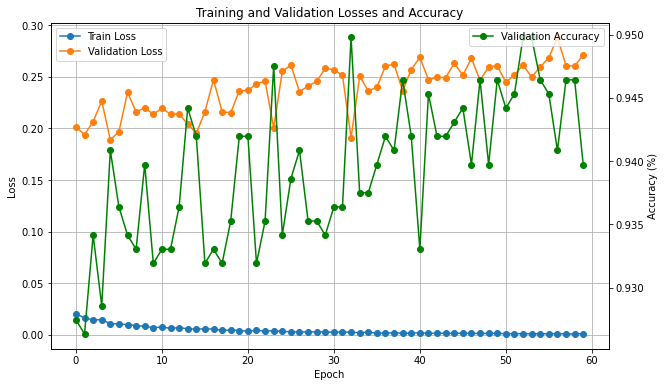

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot train and val losses on the primary y-axis
ax1.plot(df.index, df['train_losses'], label='Train Loss', marker='o')
ax1.plot(df.index, df['val_losses'], label='Validation Loss', marker='o')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Create a secondary y-axis for accuracies
ax2 = ax1.twinx()
ax2.plot(df.index, df['val_accuracies'], label='Validation Accuracy', color='green', marker='o')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Training and Validation Losses and Accuracy')
ax1.grid()

plt.show()

Train loss decreases as expected, but it's counterintuitive that validation loss trends upward and validation accuracy also follows.

We somehow have an inversed relationship between loss and accuracy. This pattern can be clearly seen at epochs 23, 33, and 40.

Maybe this is because the model gets more and more confident in its predictions as we train, thus getting penalized heavier. 

Similar phenomenon is observed in Figure 3 of [this paper](https://arxiv.org/pdf/1706.04599). I have not read this in full, but will do later to understand this better.

### Hardware utilization

During fine-tuning, `3.1GB` of my A10 GPU memory was used. Meanwhile, the LoRA process only consumed `1.4GB`. This is a significant improvement, and explains why LoRA is so widely-adopted in finetuning LLMs these days.